In [1]:
#pip install --upgrade transformers torch
#!pip install tf-keras
#!conda install tensorflow -y

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import torch
from transformers import BertModel, BertTokenizer

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense


from wordcloud import WordCloud

from tqdm import notebook

import warnings

sns.set_style('darkgrid')

warnings.filterwarnings('ignore')



/Users/daniilkorolev/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def reading_tables(path, column_names):
    df = pd.read_table(path, names=column_names)
    
    return df


## Experts

In [4]:
# 1 - не соответствует
# 2 - содежит элементы
# 3 - почти соответствует
# 4 - полностью соответствует

path = '/Users/daniilkorolev/Downloads/data/Photo searching/ExpertAnnotations.tsv'
column_names = ['photo_name', 'request_name', 'Expert 1', 'Expert 2', 'Expert 3']
Experts = reading_tables(path, column_names)

Exp_pre_shape = Experts.shape[0]
Experts

,photo_name,request_name,Expert 1,Expert 2,Expert 3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


In [5]:
Experts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   photo_name    5822 non-null   object
 1   request_name  5822 non-null   object
 2   Expert 1      5822 non-null   int64 
 3   Expert 2      5822 non-null   int64 
 4   Expert 3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


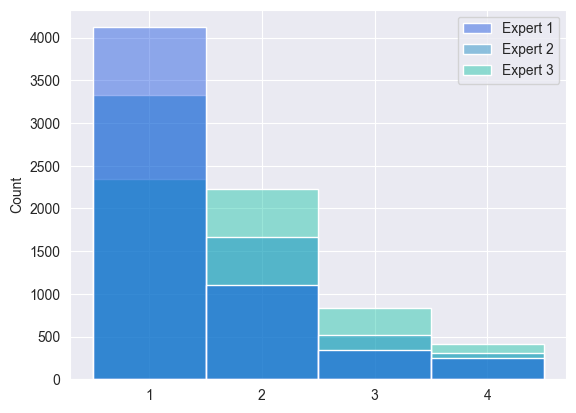

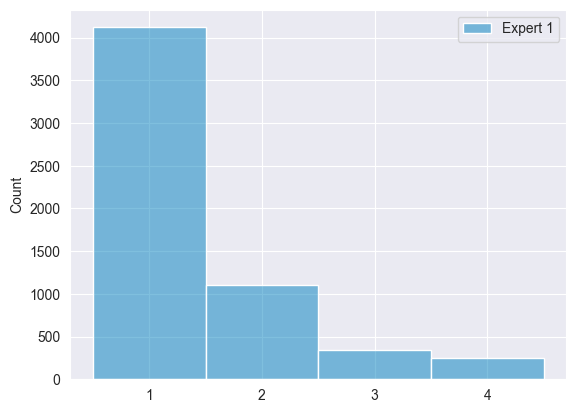

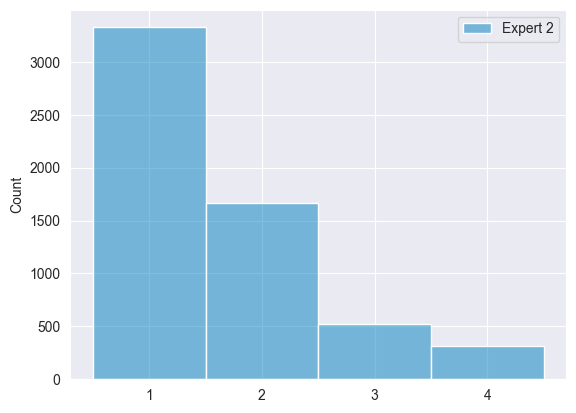

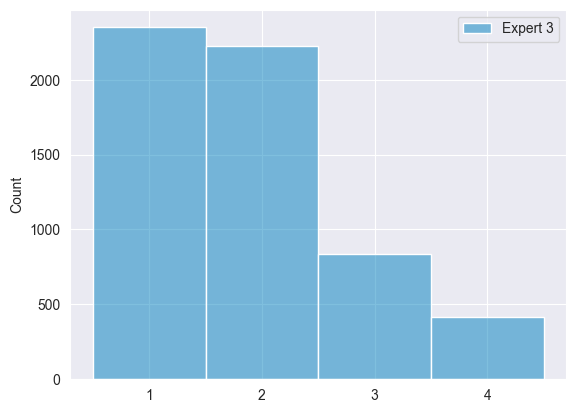

In [6]:
plt.xtics= range(1, 5, 1)
sns.histplot(Experts[['Expert 1', 'Expert 2', 'Expert 3']], alpha=0.4, palette='winter', discrete=True, binwidth=1);

plt.xticks(ticks=[1, 2, 3, 4])
plt.show()


def expert_hist(Expert):
    sns.histplot(Experts[[Expert]], palette='winter', discrete=True, binwidth=0.5)
    plt.xticks(ticks=[1, 2, 3, 4])
    plt.show()

for i in range(1, 4, 1):
    expert_hist('Expert' + ' ' + str(i))

Возможно эксперты 1 и 3 предвзяты, хотя возможно что данные имеют такую специфичную структуру

In [7]:
duplicates_subset = Experts[Experts.duplicated(subset=['Expert 1', 'Expert 2', 'Expert 3'], keep=False)]

In [8]:
duplicates_subset

,photo_name,request_name,Expert 1,Expert 2,Expert 3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


In [9]:
def get_consensus(row):
    expert_scores = [row['Expert 1'], row['Expert 2'], row['Expert 3']]
    score_counts = pd.Series(expert_scores).value_counts()
    
    for score, count in score_counts.items():
        if count == 2 or count == 3:
            return score
    return None
        
    
Experts['consensus_score'] = Experts.apply(get_consensus, axis=1)
print(Experts.isna().sum())

Experts = Experts.dropna()

Experts_cons = Experts[['photo_name', 'request_name', 'consensus_score']]
#Experts_cons = Experts.query('consensus_score > 2')

Exp_after_shape = Experts_cons.shape[0]
Experts_cons

photo_name           0
request_name         0
Expert 1             0
Expert 2             0
Expert 3             0
consensus_score    126
dtype: int64


,photo_name,request_name,consensus_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0
...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1.0
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1.0
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1.0
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1.0


In [10]:
def before_after(before, after):
    print(f'Значения до {before}\
            значения после {after},\
            уменьшение на {round((before - after) / before * 100, 2)}%')


before_after(Exp_pre_shape,  Exp_after_shape)

Значения до 5822            значения после 5696,            уменьшение на 2.16%


## Crowd

In [11]:
### rate - это доля
# Yes - запрос соответствует изображению
# No - не соответствует

path = '/Users/daniilkorolev/Downloads/data/Photo searching/CrowdAnnotations.tsv'
column_names = ['photo_name', 'request_name', 'rate', 'Yes', 'No']

Crowd = reading_tables(path, column_names)

crowd_pre_shape = Crowd.shape[0]
Crowd.describe()
Crowd

,photo_name,request_name,rate,Yes,No
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


In [12]:
Crowd.describe()

,rate,Yes,No
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


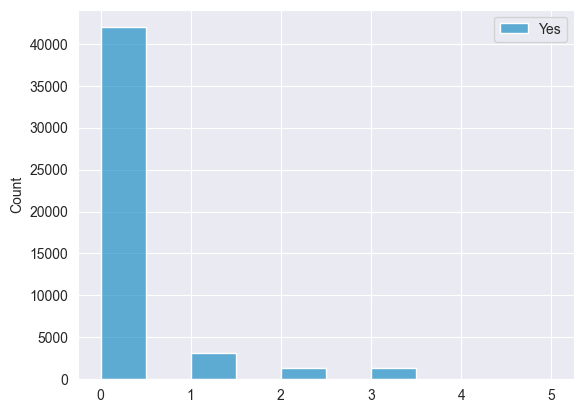

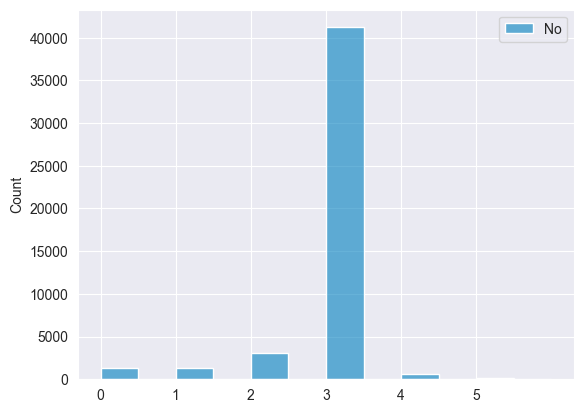

In [13]:
sns.histplot(Crowd[['Yes']], alpha=0.6, palette='winter', binwidth=0.5, bins=5)

plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.show()

sns.histplot(Crowd[['No']], alpha=0.6, palette='winter', binwidth=0.5, bins=5)

plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.show()

In [14]:
#Crowd_cons = Crowd.query('rate > 0.6')
Crowd_cons = Crowd[['photo_name', 'request_name', 'rate']]

crowd_after_shape = Crowd_cons.shape[0]

Crowd_cons

,photo_name,request_name,rate
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000
...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000


In [15]:
before_after(crowd_pre_shape, crowd_after_shape)

Значения до 47830            значения после 47830,            уменьшение на 0.0%


Нас интересуют только те запросы, которые больше половины толпы оценили как верный, поэтому считаю такое сокращение данных оправданным

## Overall rating

In [16]:
overall_df = Experts_cons.join(Crowd_cons['rate'], how='left')

expert_coefficent = 0.6
crowd_coefficent = 0.4
overall_df['final_score'] = overall_df['consensus_score'] * expert_coefficent + overall_df['rate'] * crowd_coefficent

min_max = MinMaxScaler()

min_value = overall_df['final_score'].min()
max_value = overall_df['final_score'].max()

overall_df['target_score'] = (overall_df['final_score'] - min_value) / (max_value - min_value)


overall_df

,photo_name,request_name,consensus_score,rate,final_score,target_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.000000,1.000000,0.181818
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0,0.000000,0.600000,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0,0.000000,0.600000,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,2.0,0.000000,1.200000,0.272727
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0,0.000000,0.600000,0.000000
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1.0,0.000000,0.600000,0.000000
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1.0,0.000000,0.600000,0.000000
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1.0,0.000000,0.600000,0.000000
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1.0,0.666667,0.866667,0.121212


## Train Dataset

In [17]:
train_dataset = pd.read_csv('/Users/daniilkorolev/Downloads/data/Photo searching/train_dataset.csv')

train_pre_shape = train_dataset.shape[0]

train_dataset

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


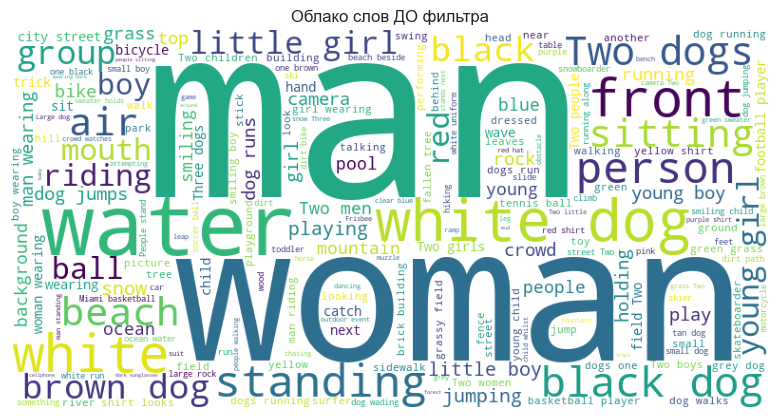

In [18]:
df = train_dataset
corpus = ' '.join(df['query_text'].astype(str).values)

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(corpus)



plt.figure(figsize = (8, 4), facecolor = None)
plt.title('Облако слов ДО фильтра')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [19]:
stop_law = ['boy', 'boys', 'girl', 'girls', 'teen', 'teens', 'child', 'children', 'toddler']

In [20]:
def stop_law_cleaner(line, stop_law_list, column):
    for word in stop_law_list:
        if word in line:
            return None
    return line

train_dataset['query_text'] = train_dataset['query_text'].apply(lambda x: stop_law_cleaner(x, stop_law, 'query_text'))

train_dataset = train_dataset.dropna()

In [21]:
train_dataset = train_dataset.join(overall_df['target_score'], how='left')

train_after_shape = train_dataset.shape[0]

In [22]:
print(train_dataset.describe())
print(train_dataset['target_score'].isna().sum())
train_dataset = train_dataset.dropna()
print(train_dataset.isna().sum(), 'ВОТ')

       target_score
count   4337.000000
mean       0.175069
std        0.234455
min        0.000000
25%        0.000000
50%        0.000000
75%        0.272727
max        0.939394
95
image           0
query_id        0
query_text      0
target_score    0
dtype: int64 ВОТ


In [23]:
before_after(train_pre_shape, train_after_shape)

Значения до 5822            значения после 4432,            уменьшение на 23.87%


С каждым шагом обработки у нас все меньше данных)

## Test Queries

In [24]:
path = '/Users/daniilkorolev/Downloads/data/Photo searching/test_queries.csv'
test_queries = pd.read_csv(path, delimiter='|', index_col='Unnamed: 0')


print(test_queries['query_text'][0])
test_queries.head(6)

Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg


## Image Embeddings

In [25]:
def get_image_embeddings(image_path):
    embeddings = []
    for path in image_path:
        img = load_img(path, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        embedding = img_model.predict(x)[0]
        embeddings.append(embedding.flatten())
        
    return np.array(embeddings)

def get_text_embeddings(queries):
    embeddings = []
    for query in queries:
        inputs = tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=128)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(embedding.flatten())
        
    return np.array(embeddings)

def combine_embeddings(image_embeddings, text_embeddings):
    combined_embeddings = np.concatenate([image_embeddings, text_embeddings], axis=1)
    return combined_embeddings

def create_matching_model(input_size, mode='NN'):
    
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(input_size,)),
        Dense(1, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    return model

def train_model(combined_embeddings, labels):
    model = create_matching_model(combined_embeddings.shape[1])
    model.fit(combined_embeddings, labels, epochs=10, batch_size=32)
    
    return model


    

In [26]:
%%time

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
img_model = Model(inputs=base_model.inputs, outputs=base_model.outputs)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


image_pathes = ['/Users/daniilkorolev/Downloads/data/Photo searching/train_images/'\
               + image_name for image_name in train_dataset['image']]

queries = train_dataset['query_text'].to_list()

img_embeddings = get_image_embeddings(image_pathes)
text_embeddings = get_text_embeddings(queries)
combined_embeddings = combine_embeddings(img_embeddings, text_embeddings)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

In [27]:
labels = train_dataset['target_score'].values
pd.DataFrame(labels).isna().sum()


0    0
dtype: int64

In [28]:
    assert not np.any(np.isnan(combined_embeddings)), "combined_embeddings содержит nan"
    assert not np.any(np.isinf(combined_embeddings)), "combined_embeddings содержит бесконечные значения"
    assert not np.any(np.isnan(labels)), "labels содержит nan"
    assert not np.any(np.isinf(labels)), "labels содержит бесконечные значения"

In [30]:

model = train_model(combined_embeddings, labels)

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.8263 - mae: 0.8263
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8229 - mae: 0.8229
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8237 - mae: 0.8237
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8247 - mae: 0.8247
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8237 - mae: 0.8237
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8238 - mae: 0.8238
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8254 - mae: 0.8254
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8216 - mae: 0.8216
Epoch 9/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8261 - mae: 0.8261
Epoch 10/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8240 - mae: 0.8240


In [ ]:
train_dataset

## Вывод, мне нужна помощь, не понимаю почему не растет метрика даже на трейне